## Transfer Learning

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models #Diferenes modelos ya entrenados, con esto importamos la red 
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import zipfile

In [ ]:
#Para que se importe de tu drive el zip del dataset
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Descomprimir el zip
zip_path = 'drive/MyDrive/archive.zip'
extract_folder = 'data'

# Create the extraction folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

KeyboardInterrupt: 

### Descargar sets de datos

In [ ]:
DATA_PATH = "data/AugmentedAlzheimerDataset/"
MINIBATCH_SIZE = 32

train_transforms = T.Compose([
                                    T.Resize((224,224)),
                                    T.RandomRotation(60),
                                       T.RandomHorizontalFlip(),
                                       T.ToTensor(),

                                       T.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = T.Compose([ T.Resize((224,224)),
                                    T.RandomRotation(60),
                                    T.ToTensor(),
                                      T.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# Descargamos los datos de datapath
midataset = datasets.ImageFolder(DATA_PATH,
                                 transform=train_transforms)

train_size = int(0.9 * len(midataset))
val_size = int(0.04 * len(midataset))
test_size = len(midataset) - train_size - val_size
train_midataset, test_midataset, val_midataset = torch.utils.data.random_split(midataset, [train_size, test_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_midataset,MINIBATCH_SIZE,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_midataset,MINIBATCH_SIZE,shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_midataset,MINIBATCH_SIZE,shuffle=False)

In [4]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Usar GPU

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)#muestra solo la gpu

cpu


### Mostrar imágenes

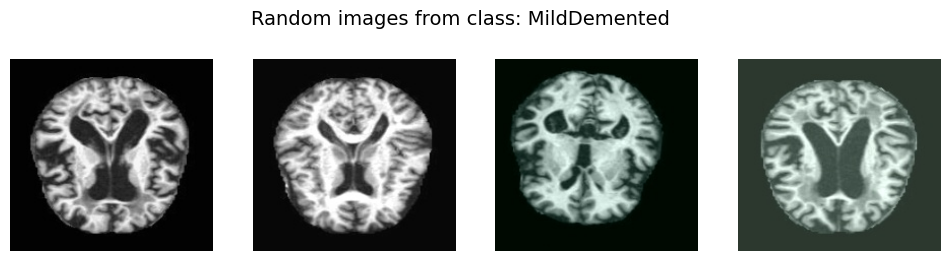

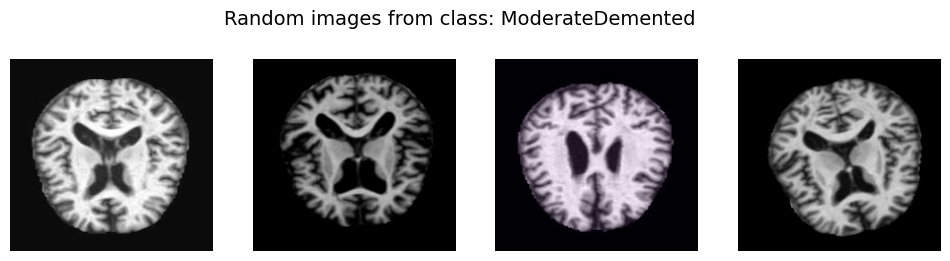

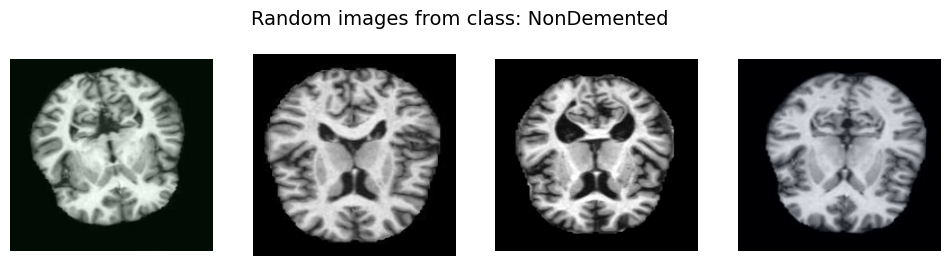

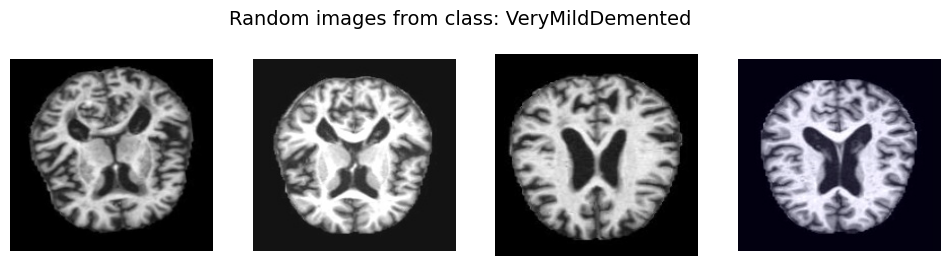

In [13]:
def plot_random_images(dataset_path):
    classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
    num_images = 4
    
    # Plot images for each class
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_folder)
        random_images = random.sample(image_files, num_images)
        
        plt.figure(figsize=(12, 3))
        plt.suptitle(f'Random images from class: {class_name}', fontsize=14)
        
        for i, image_file in enumerate(random_images):
            image_path = os.path.join(class_folder, image_file)
            image = Image.open(image_path)
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.axis('off')
            
        
        plt.show()

# Call the function with the path to your dataset folder
plot_random_images('data/AugmentedAlzheimerDataset/')



### Calcular Accuracy

In [14]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total  #numero de imagenes correctas / numero total 



### Cargar modelo pre-cargado

In [8]:
model_densenet = models.densenet121(pretrained=True)

c:\Users\celia\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\celia\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\celia/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.73MB/s]


#### Exploremos el modelo

In [9]:
for i, w in enumerate(model_densenet.parameters()):
    print(i, w.shape, w.requires_grad)#requires.grad muestra si se pueden entrenar o no los parametros, todas estan a true, pero solo queremos entrenar la ultima

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [10]:
model_densenet#para ver el modelo que es red convolucional
#se observa que la ultima capa tiene como salida 1000 neuronas

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [11]:
# model_aux = nn.Sequential(*list(model_resnet18.children()))
# model_aux
#copias del modelo, creamos modelo auxiliar al que se le pasa todas las capas, elementos del modelo de resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
# model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])
#ahora el modelo que creamos es el que teneiamos pero sin incluir la ultima capa

In [13]:
# model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
for i, parameter in enumerate(model_densenet.parameters()):
    parameter.requires_grad = False

for param in model_densenet.features.denseblock4.parameters():#solo los de este bloque se ponen a True para que se modifiquen
    param.requires_grad =True

#Se modifica la ultima capa de la red, con Dropout se desactivarán el 20% de las neuronas aleatoriamente durante cada paso del entrenamiento para que no haya sobreajuste.
model_densenet.classifier=torch.nn.Sequential(
torch.nn.Dropout(0.2,inplace=True),
torch.nn.Linear(1024,4),
   
)

In [15]:
for i, parameter in enumerate(model_densenet.parameters()):
    print(i, parameter.requires_grad)#están todos en FALSE, nose van a entrenar

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [16]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_dataloader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_dataloader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [17]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 10
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

#nuestro model1 será el modelo auxiliar sin la utlima capa pero ahora le añadimos la ultia q queramos, de forma lineal y con 10 neuronas de salida, se una flatten para forma de vector
# model1 = nn.Sequential(model_aux,
#                        nn.Flatten(), 
#                        nn.Linear(in_features=512, out_features= 4, bias= True))

optimiser = torch.optim.Adam(model_densenet.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [18]:
model_densenet

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
train(model_densenet, optimiser, epochs)

KeyboardInterrupt: 

In [24]:
accuracy(model_densenet, test_dataloader)

KeyboardInterrupt: 